## Recency, Frequency, Monetary Value
Build the RFM features matrix for each customer

Determine cutting points for each feature

Determine the RFM scores and summarize the corresponding business value

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark RFM example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
df_raw = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("OnlineRetail.csv",header=True)
df_raw.show(5)
df_raw.printSchema()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |

### Preprocess

In [3]:
#remove null
from pyspark.sql.functions import count

def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

my_count(df_raw)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   541909|   541909|     540455|  541909|     541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [4]:
# drop records with null
df = df_raw.dropna(how='any')
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   406829|   406829|     406829|  406829|     406829|   406829|    406829| 406829|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [5]:
#deal with incoice date
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col
timeFmt = "MM/dd/yy HH:mm"
df = df.withColumn('NewInvoiceDate', to_utc_timestamp(unix_timestamp(col('InvoiceDate'),timeFmt).cast('timestamp'),'UTC'))
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
+---------+-----

In [6]:
# calculate TotalPrice
from pyspark.sql.functions import round
df = df.withColumn('TotalPrice', round( df.Quantity * df.UnitPrice, 2))
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|      15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|      22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8

In [7]:
# calculate time difference
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date

date_max = df.select(max('NewInvoiceDate')).toPandas()
current = to_utc_timestamp( unix_timestamp(lit(str(date_max.iloc[0][0])), \
                              'yy-MM-dd HH:mm').cast('timestamp'), 'UTC' )
# Calculatre Duration
df = df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+--------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|Duration|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|      15.3|     373|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|     373|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|      22.0|     373|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|     20.34|     373|

In [8]:
# build the RFM
recency = df.groupBy('CustomerID').agg(min('Duration').alias('Recency'))
frequency = df.groupBy('CustomerID', 'InvoiceNo').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))
monetary = df.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))
rfm = recency.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')
rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     10|        1|   336.4|
|     17389|      0|       43|31300.08|
|     12940|     46|        4|  876.29|
|     13623|     30|        7|  672.44|
|     14450|    180|        3|  483.25|
+----------+-------+---------+--------+
only showing top 5 rows



In [9]:
def describe_pd(df_in, columns, deciles=False):
    import numpy as np
    import pandas as pd
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    :author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True, sort=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [10]:
#RFM Segmentation, use quantile
cols = ['Recency','Frequency','Monetary']
describe_pd(rfm,cols,False)

,summary,Recency,Frequency,Monetary
0,count,4372,4372,4372
1,mean,91.58119853613907,5.07548032936871,1898.4597003659658
2,stddev,100.77213931384833,9.338754163574729,8219.345141139722
3,min,0,1,-4287.63
4,max,373,248,279489.02
5,25%,16,1,293.362
6,50%,50,3,648.075
7,75%,143,5,1611.72


In [11]:
# define the cutting point
from pyspark.sql.functions import col, concat

def RScore(x):
    if  x <= 16:
        return 1
    elif x<= 50:
        return 2
    elif x<= 143:
        return 3
    else:
        return 4

def FScore(x):
    if  x <= 1:
        return 4
    elif x <= 3:
        return 3
    elif x <= 5:
        return 2
    else:
        return 1

def MScore(x):
    if  x <= 293:
        return 4
    elif x <= 648:
        return 3
    elif x <= 1611:
        return 2
    else:
        return 1

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())

#create segment
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

rfm_seg = rfm_seg.withColumn('RFMScore',concat(col('r_seg'), col('f_seg'), col('m_seg')))
#rfm_seg.sort(col('RFMScore')).show(5)
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     15619|     10|        1|   336.4|    1|    4|    3|
|     17389|      0|       43|31300.08|    1|    1|    1|
|     12940|     46|        4|  876.29|    2|    2|    2|
|     13623|     30|        7|  672.44|    2|    1|    2|
|     14450|    180|        3|  483.25|    4|    3|    3|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     15619|     10|        1|   336.4|    1|    4|    3|     143|
|     17389|      0|       43|31300.08|    1|    1|    1|     111|
|     12940|     46|        4|  876.29|    2|    2|    2|     222|
|     13623|     30|        7|  672.44|    2|    1|

In [12]:
#Statistical summary
rfm_seg.groupBy('RFMScore')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} )\
        .sort(col('RFMScore')).show(5)

+--------+-----------------+------------------+------------------+
|RFMScore|     avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+--------+-----------------+------------------+------------------+
|     111|6.035123966942149| 8828.888595041324|18.882231404958677|
|     112|7.237113402061856|1223.3604123711339| 7.752577319587629|
|     113|              8.0|          505.9775|               7.5|
|     114|             11.0|            191.17|               8.0|
|     121|6.472727272727273|2569.0619999999994| 4.636363636363637|
+--------+-----------------+------------------+------------------+
only showing top 5 rows



In [13]:
# also can use Kmeans for segment
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm'])

rfm.show(5)
transformed= transData(rfm)
transformed.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     10|        1|   336.4|
|     17389|      0|       43|31300.08|
|     12940|     46|        4|  876.29|
|     13623|     30|        7|  672.44|
|     14450|    180|        3|  483.25|
+----------+-------+---------+--------+
only showing top 5 rows

+----------+-------------------+
|CustomerID|                rfm|
+----------+-------------------+
|     15619|   [10.0,1.0,336.4]|
|     17389|[0.0,43.0,31300.08]|
|     12940|  [46.0,4.0,876.29]|
|     13623|  [30.0,7.0,672.44]|
|     14450| [180.0,3.0,483.25]|
+----------+-------------------+
only showing top 5 rows



In [14]:
# scaling the rfm
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="rfm",\
         outputCol="features")
scalerModel =  scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)
scaledData.show(5,False)

+----------+-------------------+---------------------------------------------------------------+
|CustomerID|rfm                |features                                                       |
+----------+-------------------+---------------------------------------------------------------+
|15619     |[10.0,1.0,336.4]   |[0.02680965147453083,0.0,0.016294610567853272]                 |
|17389     |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |
|12940     |[46.0,4.0,876.29]  |[0.12332439678284182,0.012145748987854251,0.01819712791732512] |
|13623     |[30.0,7.0,672.44]  |[0.08042895442359249,0.024291497975708502,0.017478781288030567]|
|14450     |[180.0,3.0,483.25] |[0.48257372654155495,0.008097165991902834,0.01681209500499777] |
+----------+-------------------+---------------------------------------------------------------+
only showing top 5 rows



In [15]:
scaledData.describe().show()

+-------+------------------+
|summary|        CustomerID|
+-------+------------------+
|  count|              4372|
|   mean|15299.677721866423|
| stddev|1722.3907054276908|
|    min|             12346|
|    max|             18287|
+-------+------------------+



In [16]:
#Elbow method to determine the optimal number of clusters for k-means
def optimal_k(data,k_min, k_max, featureName="indexedFeatures"):
    import numpy as np
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import ClusteringEvaluator
    import time

    max_cluster=k_max+1
    cost = np.zeros(max_cluster)
    silh_val=np.zeros(max_cluster)

    for k in range(k_min,max_cluster):
        t=time.time()
        local_time = time.ctime(t)

        print("k=: ",k, "time=: ", local_time)
        kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol(featureName)\
            .setPredictionCol("cluster")

        kmodel = kmeans.fit(data)
        cost[k] = kmodel.computeCost(data) # requires Spark 2.0 or later
    
        # Make predictions
        kpredictions = kmodel.transform(data)
        # Evaluate clustering by computing Silhouette score
        evaluator = ClusteringEvaluator(predictionCol='cluster')
        silhouette = evaluator.evaluate(kpredictions)
        silh_val[k]=silhouette

    import matplotlib.pyplot as plt
    %matplotlib inline
    from matplotlib.ticker import MaxNLocator

    fig, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6))
    ax1.plot(range(k_min,max_cluster),cost[k_min:max_cluster])
    ax1.set_xlabel('k')
    ax1.set_ylabel('cost')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2.plot(range(k_min,max_cluster),silh_val[k_min:max_cluster])
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()

k=:  2 time=:  Wed Apr 15 17:34:36 2020
k=:  3 time=:  Wed Apr 15 17:44:59 2020
k=:  4 time=:  Wed Apr 15 17:55:24 2020
k=:  5 time=:  Wed Apr 15 18:05:59 2020
k=:  6 time=:  Wed Apr 15 18:16:32 2020
k=:  7 time=:  Wed Apr 15 18:27:11 2020
k=:  8 time=:  Wed Apr 15 18:37:37 2020
k=:  9 time=:  Wed Apr 15 18:48:01 2020
k=:  10 time=:  Wed Apr 15 18:58:22 2020


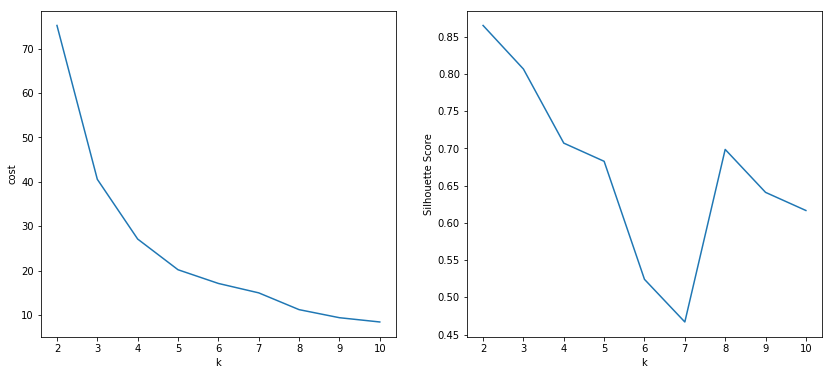

In [17]:
optimal_k(scaledData,k_min=2, k_max=10,featureName="features")

In [19]:
#use Kmean, use k=3
from pyspark.ml.clustering import KMeans

k = 3
kmeans = KMeans().setK(k).setSeed(1)
kmodel = kmeans.fit(scaledData)
# Make predictions
kpredictions = kmodel.transform(scaledData)
kpredictions.show(5,False)

+----------+-------------------+---------------------------------------------------------------+----------+
|CustomerID|rfm                |features                                                       |prediction|
+----------+-------------------+---------------------------------------------------------------+----------+
|15619     |[10.0,1.0,336.4]   |[0.02680965147453083,0.0,0.016294610567853272]                 |0         |
|17389     |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |0         |
|12940     |[46.0,4.0,876.29]  |[0.12332439678284182,0.012145748987854251,0.01819712791732512] |0         |
|13623     |[30.0,7.0,672.44]  |[0.08042895442359249,0.024291497975708502,0.017478781288030567]|0         |
|14450     |[180.0,3.0,483.25] |[0.48257372654155495,0.008097165991902834,0.01681209500499777] |2         |
+----------+-------------------+---------------------------------------------------------------+----------+
only showing top 5 rows



In [23]:
# Summary
results = rfm.join(kpredictions.select('CustomerID','prediction'),'CustomerID',how='left')
results.show(5)

+----------+-------+---------+--------+----------+
|CustomerID|Recency|Frequency|Monetary|prediction|
+----------+-------+---------+--------+----------+
|     13098|      1|       41|28658.88|         0|
|     13248|    124|        2|  465.68|         2|
|     13452|    259|        2|   590.0|         1|
|     13460|     29|        2|  183.44|         0|
|     13518|     85|        1|  659.44|         0|
+----------+-------+---------+--------+----------+
only showing top 5 rows



In [27]:
#summary on prediction
results.groupBy('prediction')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} ).sort(col('prediction')).show(5)

+----------+------------------+------------------+------------------+
|prediction|      avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+----------+------------------+------------------+------------------+
|         0|30.966337980278816|2543.0355321319284| 6.514450867052023|
|         1|296.02403846153845|407.16831730769206|1.5592948717948718|
|         2|154.40148698884758| 702.5096406443623| 2.550185873605948|
+----------+------------------+------------------+------------------+

